In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
from IPython.display import clear_output
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, Concatenate, ReLU, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from catboost import CatBoostClassifier
from xgboost import XGBRFClassifier, XGBClassifier
from itertools import product
import logging
import json, codecs, pickle

np.random.seed(0)
tf.random.set_seed(0)

2023-04-08 16:58:40.055721: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
# import telegram_client as tc
# telegram_creds = json.load(open("telegram_private.json"))
# telegram_bot = tc.TelegramClient(token=telegram_creds['token'], giga_chats={telegram_creds['chat_id']})

In [3]:
df = pd.read_csv('a.csv')
df = df.reindex(np.random.permutation(df.index))
df['n_tasks'] = df['n_tasks'].apply(lambda x: [int(item) for item in x[1:-1].split(',')])

In [4]:
sequences = np.array(list(df['n_tasks'].values))

In [5]:
sequences2 = sequences[(sequences > 0).sum(axis=1) > 30]
sequences2.shape

(3444, 305)

In [6]:
train, test = train_test_split(sequences2, test_size=0.2)

In [7]:
n_accesses_by_week = (train > 0).sum(axis=0)
accesses_diff = np.abs(n_accesses_by_week[1:] - n_accesses_by_week[:-1])
n_accesses_by_week, accesses_diff

(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    1,   79,   76,   80,    0,   11,   83,
          85,   60,   76,   54,   89,   40,   21,   74,   84,  100,   99,
         101,    8,  103,  103,  100,  100,  103,   93,   84,   85,   78,
          95,  102,   97,   79,  109,   90,  102,   89,   84,   60,   85,
          70,   98,   77,   45,   40,   84,   87,    9,  108,   92,  108,
         144,  148,  141,  139,   65,   27,   96,  112,  116,  107,  107,
         117,  117,  116,   98,  143,   95,  136,  112,  150,  139,  155,
          79,   90,  155,  158,  117,  145,  102,   48,  118,   82,  121,
         391,  337,  156,  119,  196,  199,  288,  122,  124,   75,  301,
         262,  303,  278,  316,  103, 

In [8]:
def GetLSTM() -> Sequential:
    return Sequential([
        Input(shape=(30,1)),
        LSTM(8, return_sequences=True),
        LSTM(8, return_sequences=True),
        Flatten(),
        Dense(10, activation='relu', kernel_regularizer='l1_l2'),
        Dense(2)
    ])

def GetMLP() -> Sequential:
    return Sequential([
        Input(shape=(30, 1)),
        Flatten(),
        Dense(40),
        BatchNormalization(),
        ReLU(),
        Dense(20),
        BatchNormalization(),
        ReLU(),
        Dense(2)
    ])

def GetFCN() -> Sequential:
    return Sequential([
        Input(shape=(30, 1)),
        Conv1D(20, 15, activation='relu', kernel_regularizer='l1_l2'),
        BatchNormalization(),
        Conv1D(40, 7, activation='relu', kernel_regularizer='l1_l2'),
        BatchNormalization(),
        Flatten(),
        Dense(2)
    ])

def GetCATBoost() -> CatBoostClassifier:
    return CatBoostClassifier(iterations=1200, loss_function='Logloss')

def GetLogisticRegression() -> LogisticRegression:
    return LogisticRegression(max_iter=1000)

def GetXGBoost() -> XGBClassifier:
    return XGBClassifier(eval_metric='logloss')

def GetXGBRFBoost() -> XGBRFClassifier:
    return XGBRFClassifier(eval_metric='logloss')

def GetAdaBoost() -> AdaBoostClassifier:
    return AdaBoostClassifier(n_estimators=200)

In [9]:

N_WEEKS = 30

def GetMetricsForPredictions(y_true: np.ndarray, y_pred: np.ndarray) -> dict:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    try:
        conf_mat = confusion_matrix(y_true, y_pred, labels=2).astype(int)
        conf_mat_dict = {
            'TP': conf_mat[0, 0],
            'FP': conf_mat[0, 1],
            'FN': conf_mat[1, 0],
            'TN': conf_mat[1, 1]
        }
    except Exception as e:
        conf_mat_dict = {}
    return {
        'classification_report': report_dict,
        'confusion_matrix': conf_mat_dict
    }
    

def CompileAndTrainTestModels(model: Sequential,
                              X_train_current_week: np.ndarray,
                              y_train_current_week: np.ndarray,
                              X_test_current_week: np.ndarray,
                              y_test_current_week: np.ndarray,
                              X_train_next_week: np.ndarray,
                              y_train_next_week: np.ndarray,
                              X_test_next_week: np.ndarray,
                              y_test_next_week: np.ndarray
) -> dict:
    model_result = {}
    check_point = ModelCheckpoint(
        'best_model.h5', monitor='val_loss', save_best_only=True
    )
    early_stop = EarlyStopping(patience=4, min_delta=0.0005, verbose=1)
    model.compile(
        loss=SparseCategoricalCrossentropy(from_logits=True),
        optimizer='adam',
        metrics=['accuracy']
    )
    history = model.fit(X_train_current_week, y_train_current_week, 
                        epochs=100, 
                        validation_data=(X_test_current_week, y_test_current_week), 
                        callbacks=[check_point])
    best_model = tf.keras.models.load_model('best_model.h5')
    
    y_pred_current_week = best_model.predict(X_test_current_week)
    y_pred_next_week_train = best_model.predict(X_train_next_week)
    y_pred_next_week_test = best_model.predict(X_test_next_week)
    y_pred_current_week = np.argmax(y_pred_current_week, axis=1)
    y_pred_next_week_train = np.argmax(y_pred_next_week_train, axis=1)
    y_pred_next_week_test = np.argmax(y_pred_next_week_test, axis=1)
    
    model_result['metrics'] = {}
    # model_result['metrics']['auc'] = history.history['auc']
    # model_result['metrics']['val_auc'] = history.history['val_auc']
    model_result['metrics']['accuracy'] = history.history['accuracy']
    model_result['metrics']['val_accuracy'] = history.history['val_accuracy']
    model_result['metrics']['val_loss'] = history.history['val_loss']
    model_result['current_week_metrics'] = GetMetricsForPredictions(y_test_current_week, y_pred_current_week)
    model_result['next_week_train_metrics'] = GetMetricsForPredictions(y_train_next_week, y_pred_next_week_train)
    model_result['next_week_test_metrics'] = GetMetricsForPredictions(y_test_next_week, y_pred_next_week_test)
    return model_result


def GetMetricsForNonKerasModels(model,
                                X_test_current_week: np.ndarray,
                                y_test_current_week: np.ndarray,
                                X_train_next_week: np.ndarray,
                                y_train_next_week: np.ndarray,
                                X_test_next_week: np.ndarray,
                                y_test_next_week: np.ndarray,
                                losses: list
) -> dict:
    y_pred_current_week = model.predict(X_test_current_week)
    y_pred_next_week_train = model.predict(X_train_next_week)
    y_pred_next_week_test = model.predict(X_test_next_week)
    model_result = {}
    model_result['metrics'] = {}
    model_result['metrics']['val_loss'] = losses
    model_result['current_week_metrics'] = GetMetricsForPredictions(y_test_current_week, y_pred_current_week)
    model_result['next_week_train_metrics'] = GetMetricsForPredictions(y_train_next_week, y_pred_next_week_train)
    model_result['next_week_test_metrics'] = GetMetricsForPredictions(y_test_next_week, y_pred_next_week_test)
    return model_result


def TrainAllModels(week_id: int):
    X_train = train[:, week_id-N_WEEKS:week_id]
    X_test = test[:, week_id-N_WEEKS:week_id]
    y_train = (train[:, week_id] > 0).astype(int)
    y_test = (test[:, week_id] > 0).astype(int)
    
    y_train = y_train[X_train.sum(axis=1) > N_WEEKS]
    y_test = y_test[X_test.sum(axis=1) > N_WEEKS]
    X_train = X_train[X_train.sum(axis=1) > N_WEEKS]
    X_test = X_test[X_test.sum(axis=1) > N_WEEKS]
    
    X_train_next_week = train[:, week_id-N_WEEKS+1:week_id+1]
    X_test_next_week = test[:, week_id-N_WEEKS+1:week_id+1]
    y_train_next_week = (train[:, week_id+1] > 0).astype(int)
    y_test_next_week = (test[:, week_id+1] > 0).astype(int)
    
    y_train_next_week = y_train_next_week[X_train_next_week.sum(axis=1) > N_WEEKS]
    y_test_next_week = y_test_next_week[X_test_next_week.sum(axis=1) > N_WEEKS]
    X_train_next_week = X_train_next_week[X_train_next_week.sum(axis=1) > N_WEEKS]
    X_test_next_week = X_test_next_week[X_test_next_week.sum(axis=1) > N_WEEKS]
    
    results = {}
    
    # Get data balance info
    results['balance'] = {
        'train': y_train.sum() / y_train.shape[0],
        'test': y_test.sum() / y_test.shape[0],
        'train_next_week': y_train_next_week.sum() / y_train_next_week.shape[0],
        'test_next_week': y_test_next_week.sum() / y_test_next_week.shape[0]
    }
    
    # Prepare keras data
    X_train_keras = np.expand_dims(X_train, axis=2)
    X_test_keras = np.expand_dims(X_test, axis=2)
    X_train_next_week_keras = np.expand_dims(X_train_next_week, axis=2)
    X_test_next_week_keras = np.expand_dims(X_test_next_week, axis=2)
    
    # Validate LSTM
    lstm = GetLSTM()
    results['lstm'] = CompileAndTrainTestModels(
        lstm, 
        X_train_keras, y_train, 
        X_test_keras, y_test, 
        X_train_next_week_keras, y_train_next_week, 
        X_test_next_week_keras, y_test_next_week
    )
    # Validate MLP
    mlp = GetMLP()
    results['mlp'] = CompileAndTrainTestModels(
        mlp,
        X_train_keras, y_train, 
        X_test_keras, y_test, 
        X_train_next_week_keras, y_train_next_week, 
        X_test_next_week_keras, y_test_next_week
    )
    # Validate FCN
    fcn = GetFCN()
    results['fcn'] = CompileAndTrainTestModels(
        fcn,
        X_train_keras, y_train, 
        X_test_keras, y_test, 
        X_train_next_week_keras, y_train_next_week, 
        X_test_next_week_keras, y_test_next_week
    )
    # Validate XGBoost
    xgboost = GetXGBoost()
    history = xgboost.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    losses = history.evals_result()['validation_0']['logloss']
    results['xgboost'] = GetMetricsForNonKerasModels(
        xgboost,
        X_test, y_test,
        X_train_next_week, y_train_next_week,
        X_test_next_week, y_test_next_week,
        losses
    )
    # Validate RFXGBoost
    xgbrfboost = GetXGBRFBoost()
    history = xgbrfboost.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    losses = history.evals_result()['validation_0']['logloss']
    results['xgbrfboost'] = GetMetricsForNonKerasModels(
        xgbrfboost,
        X_test, y_test,
        X_train_next_week, y_train_next_week,
        X_test_next_week, y_test_next_week,
        losses
    )
    # Validate CATBoost
    catboost = GetCATBoost()
    history = catboost.fit(X_train, y_train, eval_set=[(X_test, y_test)])
    losses = history.get_evals_result()['validation']['Logloss']
    results['catboost'] = GetMetricsForNonKerasModels(
        catboost,
        X_test, y_test,
        X_train_next_week, y_train_next_week,
        X_test_next_week, y_test_next_week,
        losses
    )
    # Validate AdaBoost
    adaboost = GetAdaBoost()
    history = adaboost.fit(X_train, y_train)
    losses = []
    results['adaboost'] = GetMetricsForNonKerasModels(
        adaboost,
        X_test, y_test,
        X_train_next_week, y_train_next_week,
        X_test_next_week, y_test_next_week,
        losses
    )
    #Validate LogisticRegression
    regression = GetLogisticRegression()
    history = regression.fit(X_train, y_train)
    losses = []
    results['log_reg'] = GetMetricsForNonKerasModels(
        regression,
        X_test, y_test,
        X_train_next_week, y_train_next_week,
        X_test_next_week, y_test_next_week,
        losses
    )
    clear_output()
    return results

In [10]:
def GetProd():
    return product(
        ('cur', 'ntr', 'nte'),
        ('f1_0', 'f1_1', 'accuracy', 'f1_macro')
    )

def UpdateBestEstimatorGrades(estimator_scores, week_result) -> dict:
    plot_metrics = {
        'cur': {'f1_0': [], 'f1_1': [], 'accuracy': [], 'f1_macro': []},
        'ntr': {'f1_0': [], 'f1_1': [], 'accuracy': [], 'f1_macro': []},
        'nte': {'f1_0': [], 'f1_1': [], 'accuracy': [], 'f1_macro': []},
    }
    plot_metrics['keys'] = list([key for key in week_result.keys() if key != 'balance'])
    for key in plot_metrics['keys']:
        plot_metrics['cur']['f1_0'].append(week_result[key]['current_week_metrics']['classification_report']['0']['f1-score'])
        plot_metrics['cur']['f1_1'].append(week_result[key]['current_week_metrics']['classification_report']['1']['f1-score'])
        plot_metrics['cur']['accuracy'].append(week_result[key]['current_week_metrics']['classification_report']['accuracy'])
        plot_metrics['cur']['f1_macro'].append(week_result[key]['current_week_metrics']['classification_report']['macro avg']['f1-score'])
        plot_metrics['ntr']['f1_0'].append(week_result[key]['next_week_train_metrics']['classification_report']['0']['f1-score'])
        plot_metrics['ntr']['f1_1'].append(week_result[key]['next_week_train_metrics']['classification_report']['1']['f1-score'])
        plot_metrics['ntr']['accuracy'].append(week_result[key]['next_week_train_metrics']['classification_report']['accuracy'])
        plot_metrics['ntr']['f1_macro'].append(week_result[key]['next_week_train_metrics']['classification_report']['macro avg']['f1-score'])
        plot_metrics['nte']['f1_0'].append(week_result[key]['next_week_test_metrics']['classification_report']['0']['f1-score'])
        plot_metrics['nte']['f1_1'].append(week_result[key]['next_week_test_metrics']['classification_report']['1']['f1-score'])
        plot_metrics['nte']['accuracy'].append(week_result[key]['next_week_test_metrics']['classification_report']['accuracy'])
        plot_metrics['nte']['f1_macro'].append(week_result[key]['next_week_test_metrics']['classification_report']['macro avg']['f1-score'])
    if estimator_scores is None:
        estimator_scores = {
            'estimators': plot_metrics['keys'],
        }
        for week_type, metric in GetProd():
            estimator_scores[week_type + '_' + metric] = np.array([0.1] * len(plot_metrics['keys']))
            
    for week_type, metric in GetProd():
        metrics = np.array(plot_metrics[week_type][metric])
        diffs = metrics.max() - metrics
        estimator_scores[week_type + '_' + metric][diffs < 0.005] += 1
    return estimator_scores

In [11]:
colors = ['grey', 'lightcoral', 'sandybrown', 'darkkhaki', 'olive', 'springgreen', 'plum', 'palevioletred']
def DrawProportionLine(x: float, values: np.ndarray):
    x_values = np.array([x, x])
    values /= values.sum()
    y = 0
    for i, value in enumerate(values):
        plt.plot(x_values, [y, y + value], c=colors[i], linewidth=20)
        y += value
        if i != (values.shape[0]) - 1:
            plt.plot(x_values, [y - 0.004, y], c='black', linewidth=20)


def DrawEstimatorNames(x: float, values: list, y_offsets: np.ndarray):
    y_offsets /= y_offsets.sum()
    y = 1.02 - len(values) * 0.05
    for i, value in enumerate(values):
        plt.plot([x - 0.37, x + 0.37], [y, y], c=colors[i], linewidth=20)
        plt.text(x, y, value, ha='center', va='center', fontsize=14)
        y += 0.05

def DrawEstimatorGrades(estimator_scores: dict):
    estimators = estimator_scores['estimators']
    metric_keys = [key for key in estimator_scores.keys() if key != 'estimators']
    n_metrics = len(estimator_scores) - 1
    min_x = -n_metrics // 2
    fig = plt.figure(figsize=(24, 8))
    ax = plt.gca()
    ax.get_yaxis().set_visible(False)
    plt.ylim((0, 1))
    plt.xlim((min_x - 0.3, min_x + n_metrics + 0.5))
    plt.xticks(np.arange(min_x, min_x + n_metrics), labels=metric_keys, fontsize=14)
    for key in metric_keys:
        DrawProportionLine(min_x, np.array(estimator_scores[key]))
        min_x += 1
    DrawEstimatorNames(min_x, estimators, np.array(estimator_scores[metric_keys[-1]]))
    plt.title("Estimator results compared to others", fontsize=18)
    plt.savefig("estimator_grades.png", dpi=200, bbox_inches='tight')
    plt.show()

In [12]:
models = ['lstm', 'mlp', 'fcn', 'xgboost', 'xgbrfboost', 'catboost', 'adaboost', 'log_reg']
markdown_models = ['lstm', 'mlp', 'fcn', 'xgboost', 'xgbrfboost', 'catboost', 'adaboost', 'log\_reg']
max_model_len = max([len(model) for model in models])
def GenerateTextMessage(all_results: int, week: int):
    week_results = all_results[week]
    text_template = f"=====Week *{week}* accuracies=====\n"
    text_template += f"balance. train:{round(week_results['balance']['train'], 2)}; tnw:{round(week_results['balance']['train_next_week'], 2)}\n"
    text_template += f"---------------------------------\n"
    text_template += "model" + " " * (max_model_len - 5) + "| f1\_0 | f1\_1\n"
    f1_0 = []
    f1_1 = []
    for model in models:
        f1_0.append(week_results[model]['next_week_train_metrics']['classification_report']['0']['f1-score'])
        f1_1.append(week_results[model]['next_week_train_metrics']['classification_report']['1']['f1-score'])
    f1_0 = np.round(f1_0, 2)
    f1_1 = np.round(f1_1, 2)
    f1_0_argmax = np.argmax(f1_0)
    f1_1_argmax = np.argmax(f1_1)
    for i, (model, f1_0_val, f1_1_val) in enumerate(zip(markdown_models, f1_0, f1_1)):
        text_template += model + " " * (max_model_len - len(model)) + "| "
        if f1_0_argmax == i:
            text_template += f"*{f1_0_val}* | "
        else:
            text_template += f"{f1_0_val} | "
        if f1_1_argmax == i:
            text_template += f"*{f1_1_val}*\n"
        else:
            text_template += f"{f1_1_val}\n"
    return text_template
            


def SendResultsToTelegram(bot: tc.TelegramClient, all_results: dict, week: int):
    bot.ProcessRecievedMessages()
    text_message = GenerateTextMessage(all_results, week)
    messages = [
        tc.TelegramClientSendFields(text_message, photo_path='estimator_grades.png')
    ]
    bot.SendMessagesToUsers(messages)

In [13]:
estimator_scores = None
weeks = [week for week in range(145, train.shape[1], 1)]
all_results = {}
for week in tqdm(weeks):
    all_results[week] = TrainAllModels(week)
    json.dump(all_results, open('testing_results.json', 'w'), indent=1)
    estimator_scores = UpdateBestEstimatorGrades(estimator_scores, all_results[week])
    DrawEstimatorGrades(estimator_scores)
    SendResultsToTelegram(telegram_bot, all_results, week)
    pickle.dump(estimator_scores, open('testing_estimators.json', 'wb'))

 70%|███████   | 112/160 [2:07:37<54:41, 68.37s/it]


KeyError: '1'

In [ ]:
all_results = json.load(open('testing_results_final.json', 'r'))
estimator_scores = pickle.load(open('testing_estimators.json', 'rb'))

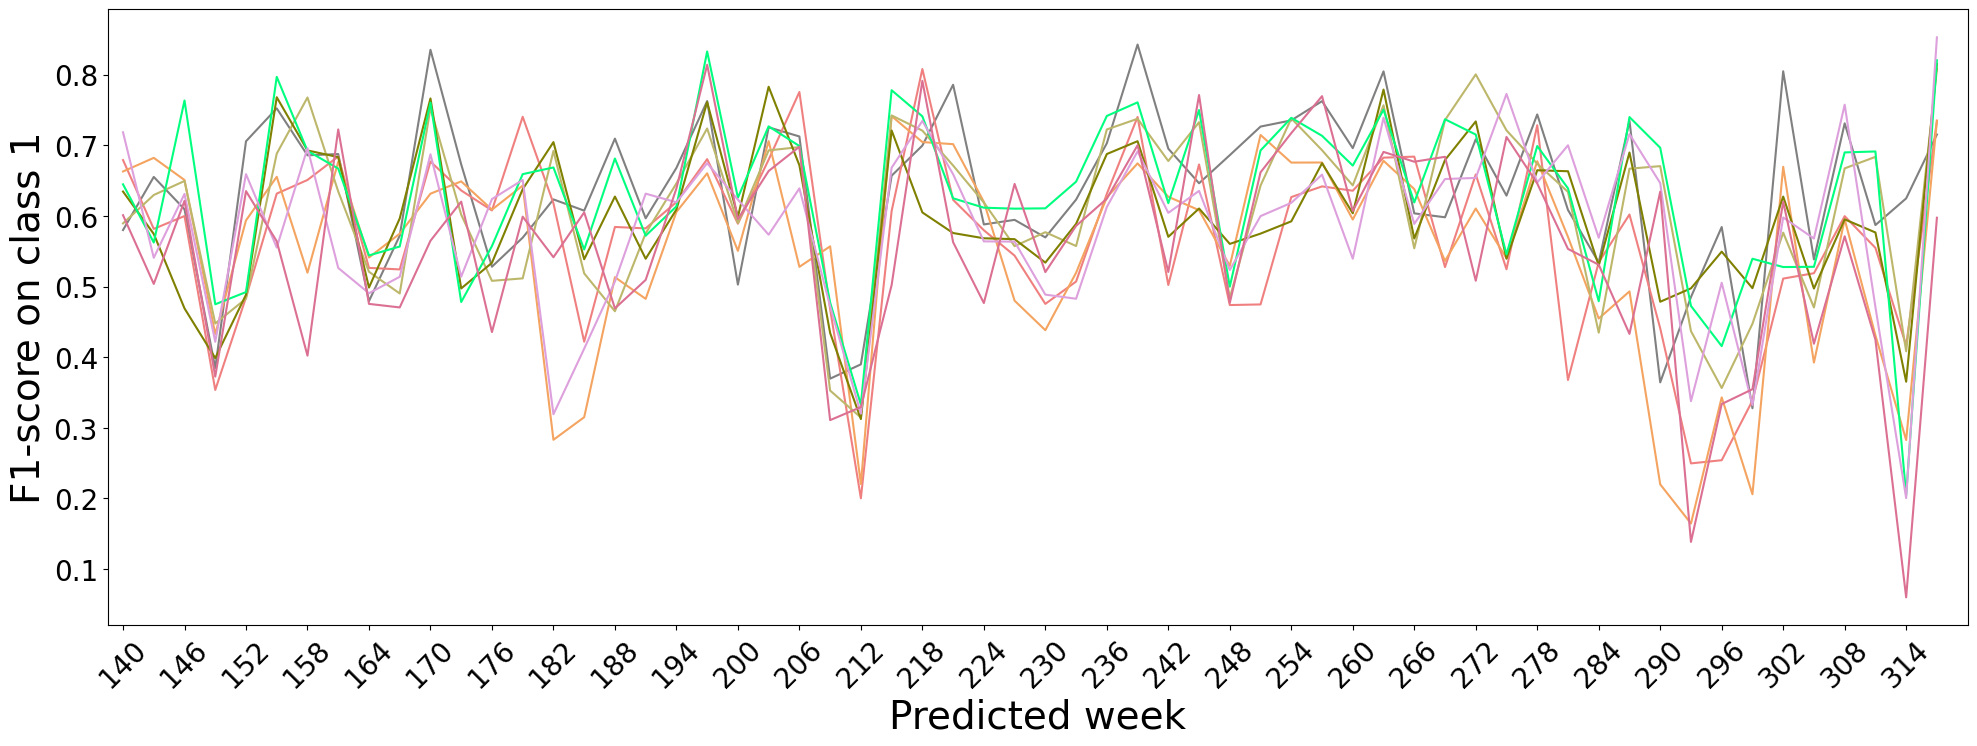

In [ ]:
fig = plt.figure(figsize=(24, 8))
ax = plt.gca()
#fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(24, 24))
reports = {}
models = [key for key in all_results['140'].keys() if key != 'balance']
weeks = list(all_results.keys())
for i, model in enumerate(models):
    reports[model] = {}
    reports_f1_0 = []
    reports_f1_1 = []
    reports_acc = []
    for week in all_results.keys():
        reports_f1_0.append(all_results[week][model]['next_week_test_metrics']['classification_report']['0']['f1-score'])
        reports_f1_1.append(all_results[week][model]['next_week_test_metrics']['classification_report']['1']['f1-score'])
        reports_acc.append(all_results[week][model]['next_week_test_metrics']['classification_report']['accuracy'])
    reports[model]['f1_0'] = reports_f1_0
    reports[model]['f1_1'] = reports_f1_1
    reports[model]['acc'] = reports_acc
    plt.plot(np.arange(len(reports_f1_1)), reports_f1_1, c=colors[i])
    # ax[1].plot(np.arange(len(reports_f1_1)), reports_f1_1, c=colors[i])
    # ax[2].plot(np.arange(len(reports_acc)), reports_acc, c=colors[i])
plt.xlim((-0.5, len(weeks)))
_ = plt.xticks(np.arange(len(weeks))[::2], labels=weeks[::2], fontsize=20, rotation=45)
plt.xlabel('Predicted week', fontsize=28)
plt.ylabel('F1-score on class 1', fontsize=28)
ax.tick_params(axis='y', labelsize=20)
plt.savefig('multi-ensemble.png', dpi=200, bbox_inches='tight')
# [ax[i].set_xlim((-0.5, len(weeks))) for i in range(3)]
# [ax[i].legend(models) for i in range(3)]
#_ = [ax[i].set_xticks(np.arange(len(weeks))[::2], labels=weeks[::2]) for i in range(3)]

In [11]:
f1_0 = dict(zip(models, [reports[model]['f1_0'] for model in models]))
f1_1 = dict(zip(models, [reports[model]['f1_1'] for model in models]))
acc = dict(zip(models, [reports[model]['acc'] for model in models]))

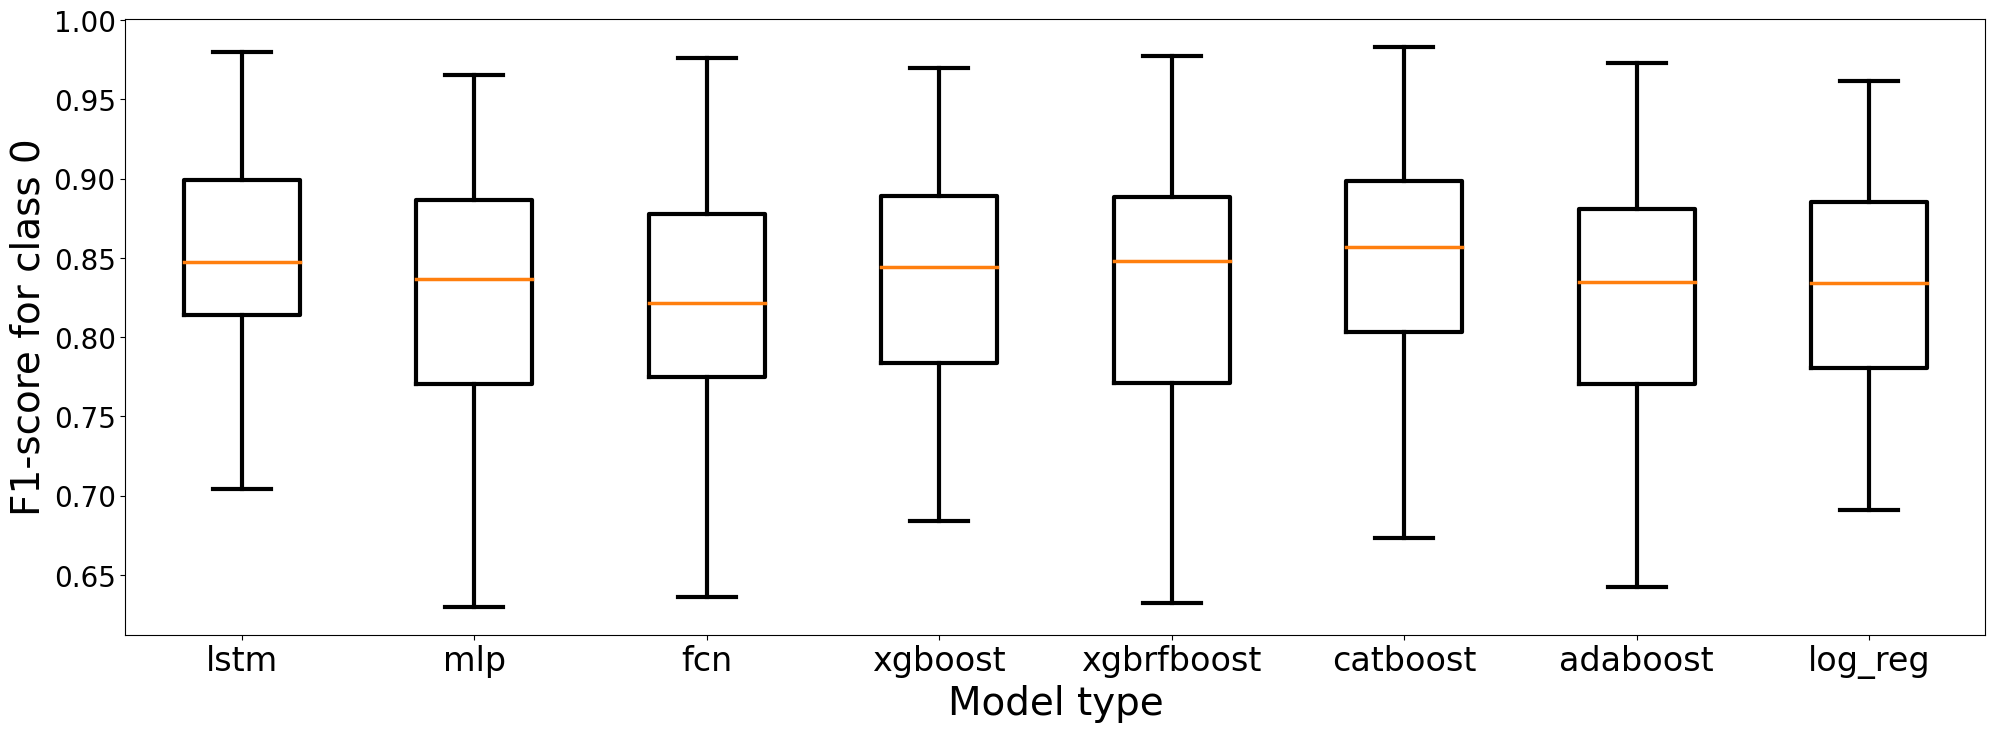

In [39]:
boxprops = dict(linewidth=3)
medianprops = dict(linewidth=2.5)
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
whiskerprops = dict(linewidth=3)
capprops = dict(linewidth=3)
flierprops = dict(marker='o', markerfacecolor='black', markersize=12,
                  markeredgecolor='none')
fig = plt.figure(figsize=(24, 8))
ax = plt.gca()
plt.boxplot(f1_0.values(), boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops)
ax.set_xticklabels(f1_0.keys())
plt.xlabel("Model type", fontsize=28)
plt.ylabel("F1-score for class 0", fontsize=28)
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=20)
plt.savefig('multi-datasets-boxplots-f1_0.png', bbox_inches='tight', dpi=200)

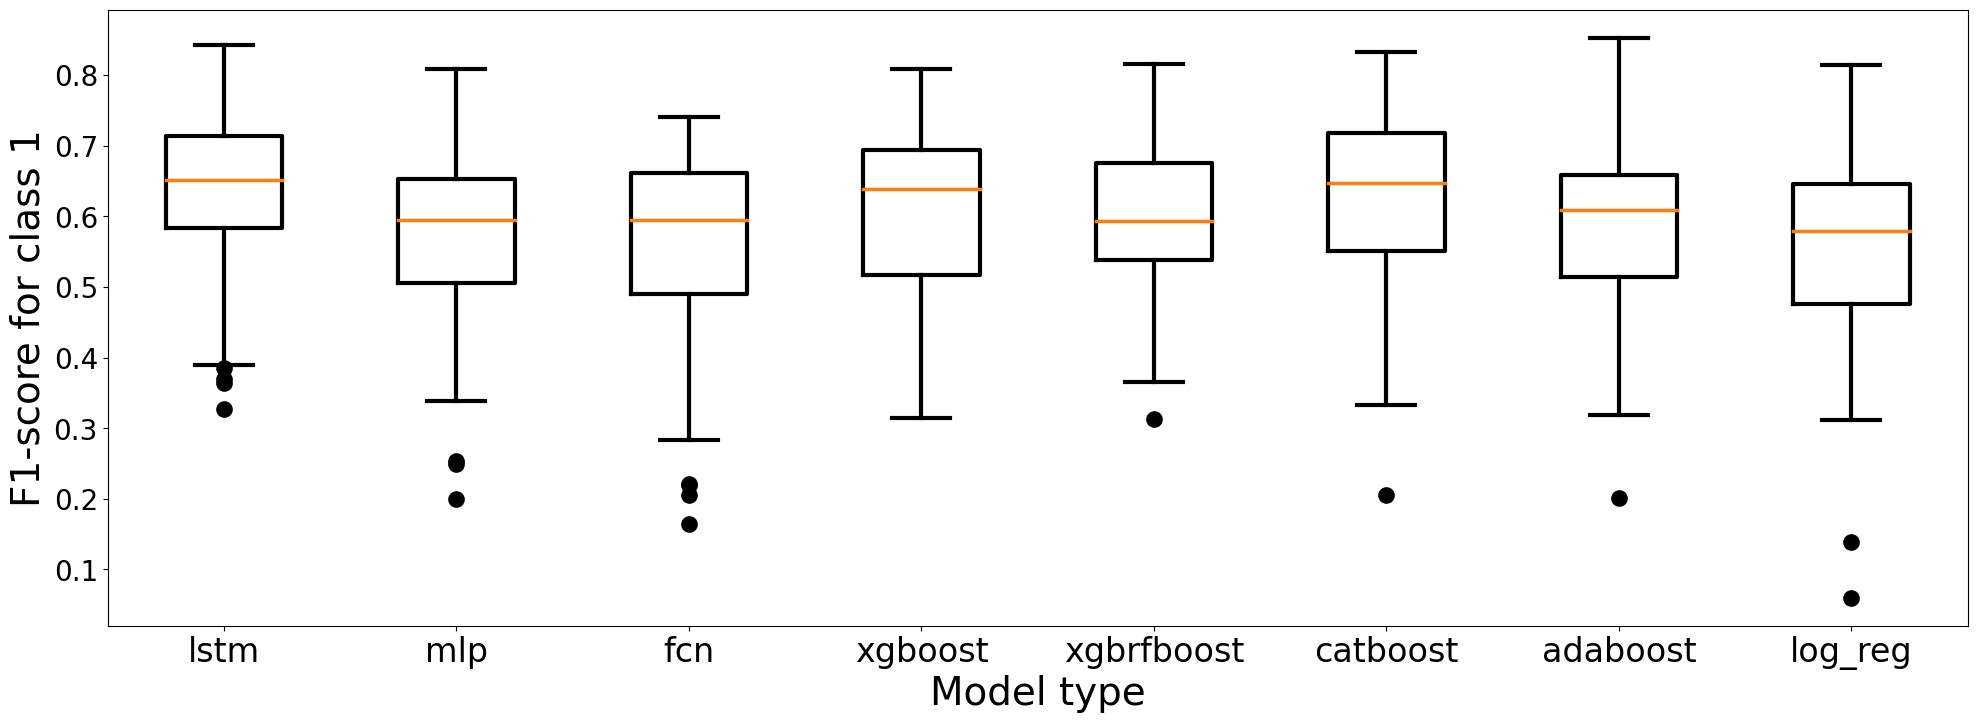

In [38]:
boxprops = dict(linewidth=3)
medianprops = dict(linewidth=2.5)
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='firebrick')
whiskerprops = dict(linewidth=3)
capprops = dict(linewidth=3)
flierprops = dict(marker='o', markerfacecolor='black', markersize=12,
                  markeredgecolor='none')
fig = plt.figure(figsize=(24, 8))
ax = plt.gca()
plt.boxplot(f1_1.values(), boxprops=boxprops, medianprops=medianprops, whiskerprops=whiskerprops, capprops=capprops, flierprops=flierprops)
ax.set_xticklabels(f1_1.keys())
plt.xlabel("Model type", fontsize=28)
plt.ylabel("F1-score for class 1", fontsize=28)
ax.tick_params(axis='x', labelsize=24)
ax.tick_params(axis='y', labelsize=20)
plt.savefig('multi-datasets-boxplots-f1_1.png', bbox_inches='tight', dpi=200)

In [48]:
from PIL import Image, ImageOps

ImageOps.grayscale(Image.open('multi-datasets-boxplots-f1_0.png')).save('multi-datasets-boxplots-f1_0_bw.pdf')
#ImageOps.grayscale(Image.open('multi-datasets-boxplots-f1_0.png')).save('multi-datasets-boxplots-f1_0.eps', quality=95)

In [27]:
table_results = np.zeros((len(reports), len(reports['lstm'])))
for i, key in enumerate(reports.keys()):
    for j, metric_key in enumerate(reports['lstm'].keys()):
        table_results[i, j] = np.median(reports[key][metric_key])
table_results

array([[0.84722745, 0.65092126, 0.79208103],
       [0.83680842, 0.5944774 , 0.76224678],
       [0.82147341, 0.59520243, 0.74788214],
       [0.84432723, 0.63897169, 0.78360958],
       [0.84784397, 0.59390078, 0.78876611],
       [0.85694406, 0.64678114, 0.79373849],
       [0.8345767 , 0.60866266, 0.76813996],
       [0.83383845, 0.57869698, 0.76427256]])